In [106]:
# Import libraries and load dataset
import os
import sys
import importlib
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import linearmodels as lm
import linearmodels.panel as lmp
import seaborn as sns

import common.common as common
importlib.reload(common)

df = pd.read_csv("Data.csv")

yr = list(df.yr)
country = list(df.country.unique())
df = df.set_index(["country", "yr"])

color = np.array([
    [c] * 13 for c in sns.color_palette("icefire", len(country)).as_hex()
]).flatten()

df["yr"] = yr
df["_color"] = color
df

lat     long  inbtou_volume  inbtou_volume_ov   
country             yr                                                        
antigua_and_barbuda 2010  17.0608 -61.7964   8.128600e+05               NaN  \
                    2011  17.0608 -61.7964   8.702400e+05               NaN   
                    2012  17.0608 -61.7964   8.426900e+05               NaN   
                    2013  17.0608 -61.7964   8.055500e+05               NaN   
                    2014  17.0608 -61.7964   7.925900e+05               NaN   
...                           ...      ...            ...               ...   
us_virgin_islands   2018  18.3358 -64.8963   1.922000e+09               NaN   
                    2019  18.3358 -64.8963   2.074000e+09               NaN   
                    2020  18.3358 -64.8963   8.620000e+08               NaN   
                    2021  18.3358 -64.8963            NaN               NaN   
                    2022  18.3358 -64.8963            NaN               NaN   

                          inbtou_volume_sd  inbtou_volume_air   
country             yr                                          
antigua_and_barbuda 2010               NaN                NaN  \
                    2011               NaN                NaN   
                    2012               NaN                NaN   
                    2013               NaN                NaN   
                    2014               NaN                NaN   
...                                    ...                ...   
us_virgin_islands   2018               NaN                NaN   
                    2019               NaN                NaN   
                    2020               NaN                NaN   
                    2021               NaN                NaN   
                    2022               NaN                NaN   

                          inbtou_volume_cruise  inbtou_spending   
country             yr                                            
antigua_and_barbuda 2010                   NaN      568930500.0  \
                    2011                   NaN      598619300.0   
                    2012                   NaN      666070300.0   
                    2013                   NaN      658851600.0   
                    2014                   NaN      595796200.0   
...                                        ...              ...   
us_virgin_islands   2018                   NaN              NaN   
                    2019                   NaN              NaN   
                    2020                   NaN              NaN   
                    2021                   NaN              NaN   
                    2022                   NaN              NaN   

                          inbtou_spending_travel  inbtou_spending_transport   
country             yr                                                        
antigua_and_barbuda 2010                     NaN                        NaN  \
                    2011                     NaN                        NaN   
                    2012                     NaN                        NaN   
                    2013                     NaN                        NaN   
                    2014                     NaN                        NaN   
...                                          ...                        ...   
us_virgin_islands   2018                     NaN                        NaN   
                    2019                     NaN                        NaN   
                    2020                     NaN                        NaN   
                    2021                     NaN                        NaN   
                    2022                     NaN                        NaN   

                          covid19_cases  covid19_deaths  covid19_mortality   
country             yr                                                       
antigua_and_barbuda 2010              0               0           0.000000  \
                    20

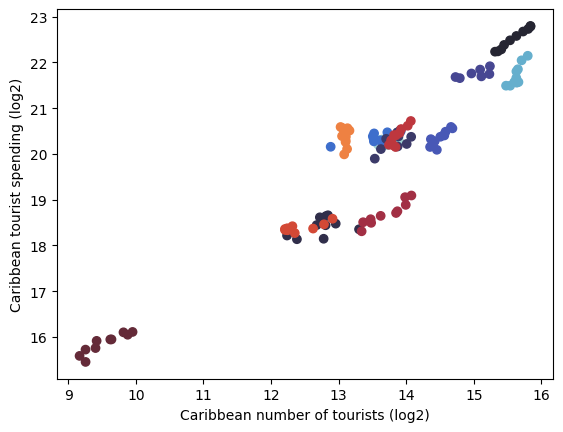

,inbtou_volume,inbtou_spending,lat,long
inbtou_volume,1.000000,0.891849,0.108845,0.049896
inbtou_spending,0.891849,1.000000,0.413995,-0.379412


In [107]:
_df = df.loc[df["yr"] < 2020]
x = _df["inbtou_volume"]
y = _df["inbtou_spending"]

plt.scatter(np.log(x), np.log(y), c=_df["_color"])
plt.xlabel("Caribbean number of tourists (log2)")
plt.ylabel("Caribbean tourist spending (log2)")
plt.show()

_df[["inbtou_volume", "inbtou_spending", "lat", "long"]].corr().iloc[[0, 1]]

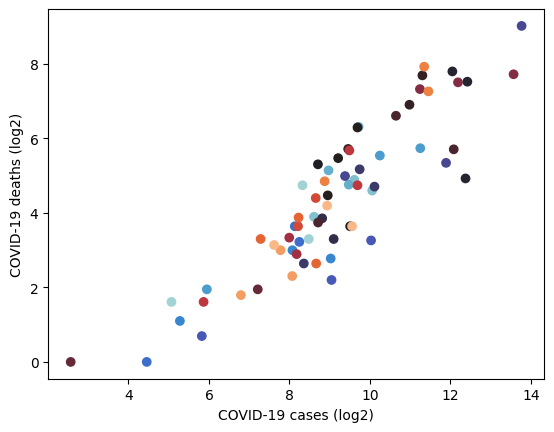

,covid19_cases,covid19_deaths,covid19_mortality,lat,long
covid19_cases,1.000000,0.835107,-0.139013,0.176720,-0.167255
covid19_deaths,0.835107,1.000000,0.064715,0.138001,-0.201407


In [121]:
_df = df.loc[(df["yr"] >= 2020) & (df["covid19_cases"] * df["covid19_deaths"] != 0)]
x = _df["covid19_cases"]
y = _df["covid19_deaths"]

plt.scatter(np.log(x), np.log(y), c=_df["_color"])
plt.xlabel("COVID-19 cases (log2)")
plt.ylabel("COVID-19 deaths (log2)")
plt.show()

_df[["covid19_cases", "covid19_deaths", "covid19_mortality", "lat", "long"]].corr().iloc[[0, 1]]

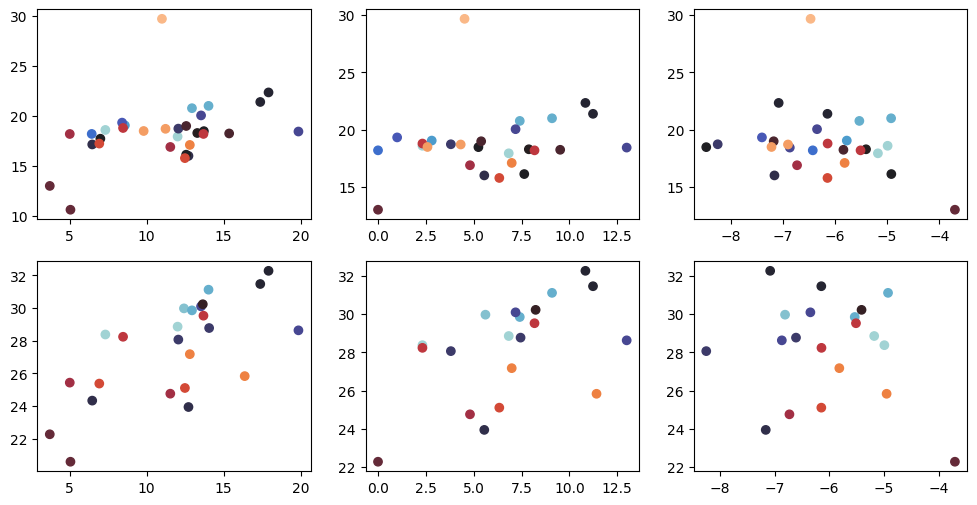

In [213]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(6)
fig.set_figwidth(12)

i, j = 0, 0
for y_name in ["inbtou_volume", "inbtou_spending"]:
    j = 0
    for x_name in ["covid19_cases", "covid19_deaths", "covid19_mortality"]:
        _df = df.loc[(df["yr"] >= 2020) & (df[x_name] != 0)]
        x = _df[x_name]
        y = _df[y_name]

        ax[i, j].scatter(np.log2(x), np.log2(y), c=_df["_color"])
        # ax[i].ylabel("Caribbean tourist volume (log2)")
        j += 1
    i += 1

# ax[0].xlabel("COVID-19 cases (log2)")
# ax[1].xlabel("COVID-19 deaths (log2)")
plt.show()

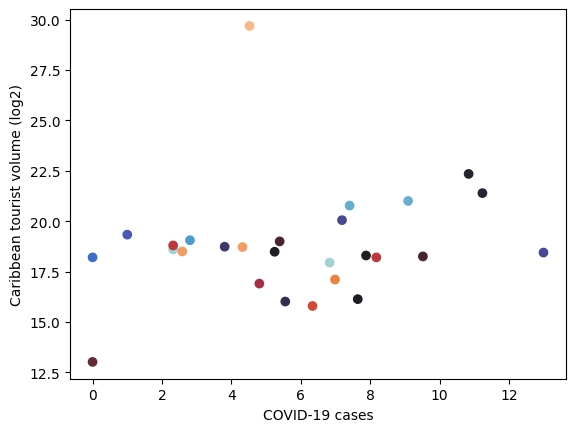

In [127]:
_df = df.loc[(df["yr"] >= 2020) & (df["covid19_deaths"] != 0)]
x = _df["covid19_deaths"]
y = _df["inbtou_volume"]

plt.scatter(np.log2(x), np.log2(y), c=_df["_color"])
plt.xlabel("COVID-19 deaths")
plt.ylabel("Caribbean tourist volume (log2)")
plt.show()

In [430]:
def fixed_effects(
    df,
    y_name:         str,
    x_vars:         list[str] = ["covid19_cases", "covid19_deaths"],
    incl_chrs:      bool = False,
    cluster_entity: bool = False,
    cluster_time:   bool = False,
):
    if incl_chrs:
        x_vars += ["lat", "long"]
    df = df[[y_name] + x_vars].dropna()

    return (
        lm.PanelOLS(df[y_name], sm.add_constant(df[x_vars])).fit(cov_type="robust")
        if not (cluster_entity or cluster_time)
        else lm.PanelOLS(df[y_name], sm.add_constant(df[x_vars]), entity_effects=True).fit(
            cov_type="clustered",
            cluster_entity=cluster_entity,
            cluster_time=cluster_time,
        )
    )

In [440]:
print(lmp.compare({
    "FE":        fixed_effects(df, "inbtou_volume"),
    "FE Entity": fixed_effects(df, "inbtou_volume", cluster_entity=True),
}))

                      Model Comparison                     
                                       FE         FE Entity
-----------------------------------------------------------
Dep. Variable               inbtou_volume     inbtou_volume
Estimator                        PanelOLS          PanelOLS
No. Observations                      219               219
Cov. Est.                          Robust         Clustered
R-squared                          0.0012         4.757e-05
R-Squared (Within)                -0.0171         4.757e-05
R-Squared (Between)                0.0023         1.188e-06
R-Squared (Overall)                0.0012            0.0001
F-statistic                        0.1248            0.0047
P-value (F-stat)                   0.8827            0.9953
=====================     ===============   ===============
const                             1.2e+08         1.175e+08
                                 (3.3239)          (1254.0)
covid19_cases                      1243.

In [441]:
print(lmp.compare({
    "FE":        fixed_effects(df, "inbtou_spending"),
    "FE Entity": fixed_effects(df, "inbtou_spending", cluster_entity=True),
}))

                        Model Comparison                       
                                         FE           FE Entity
---------------------------------------------------------------
Dep. Variable               inbtou_spending     inbtou_spending
Estimator                          PanelOLS            PanelOLS
No. Observations                        184                 184
Cov. Est.                            Robust           Clustered
R-squared                            0.0023              0.2029
R-Squared (Within)                   0.0589              0.2029
R-Squared (Between)                 -0.0025             -0.0257
R-Squared (Overall)                  0.0023             -0.0099
F-statistic                          0.2109              21.122
P-value (F-stat)                     0.8101              0.0000
=====================     =================   =================
const                             1.538e+09           1.566e+09
                                   (10.8

In [471]:
print(lmp.compare({
    "FE":        fixed_effects(df, "inbtou_volume",
                               x_vars=["covid19_mortality"]),
    "FE Entity": fixed_effects(df, "inbtou_volume",
                               x_vars=["covid19_mortality"], cluster_entity=True),
}))

                      Model Comparison                     
                                       FE         FE Entity
-----------------------------------------------------------
Dep. Variable               inbtou_volume     inbtou_volume
Estimator                        PanelOLS          PanelOLS
No. Observations                      219               219
Cov. Est.                          Robust         Clustered
R-squared                          0.0026            0.0069
R-Squared (Within)                -0.0097            0.0069
R-Squared (Between)                0.0032            0.0012
R-Squared (Overall)                0.0026            0.0017
F-statistic                        0.5764            1.3862
P-value (F-stat)                   0.4485            0.2404
=====================     ===============   ===============
const                           1.248e+08         1.202e+08
                                 (3.3028)          (38.005)
covid19_mortality              -3.492e+0

In [472]:
print(lmp.compare({
    "FE":        fixed_effects(df, "inbtou_spending",
                               x_vars=["covid19_mortality"]),
    "FE Entity": fixed_effects(df, "inbtou_spending",
                               x_vars=["covid19_mortality"], cluster_entity=True),
}))

                        Model Comparison                       
                                         FE           FE Entity
---------------------------------------------------------------
Dep. Variable               inbtou_spending     inbtou_spending
Estimator                          PanelOLS            PanelOLS
No. Observations                        184                 184
Cov. Est.                            Robust           Clustered
R-squared                            0.0126              0.0694
R-Squared (Within)                   0.0535              0.0694
R-Squared (Between)                  0.0091              0.0062
R-Squared (Overall)                  0.0126              0.0112
F-statistic                          2.3138              12.451
P-value (F-stat)                     0.1300              0.0005
=====================     =================   =================
const                             1.583e+09           1.565e+09
                                   (10.8

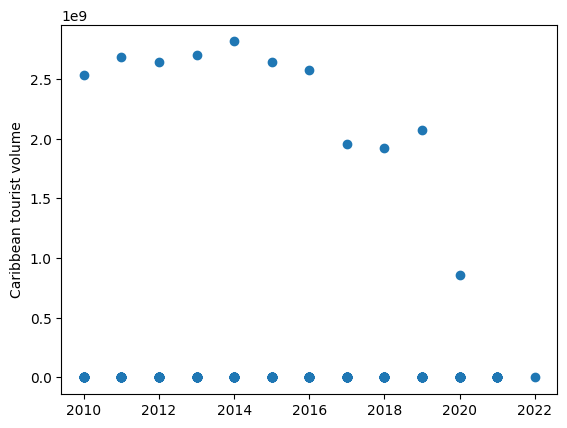

In [469]:
plt.scatter(x=df['yr'], y=df['inbtou_volume'])
plt.ylabel("Caribbean tourist volume")
plt.show()

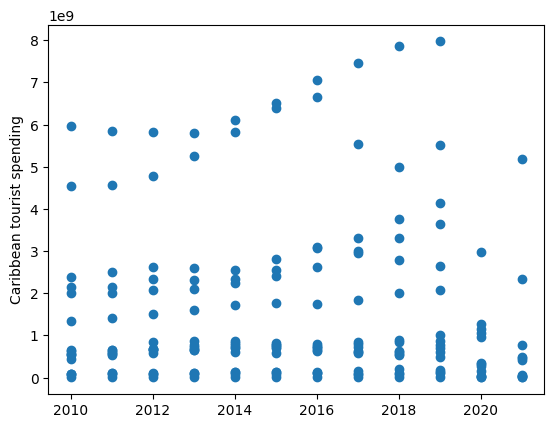

In [470]:
plt.scatter(x=df['yr'], y=df['inbtou_spending'])
plt.ylabel("Caribbean tourist spending")
plt.show()

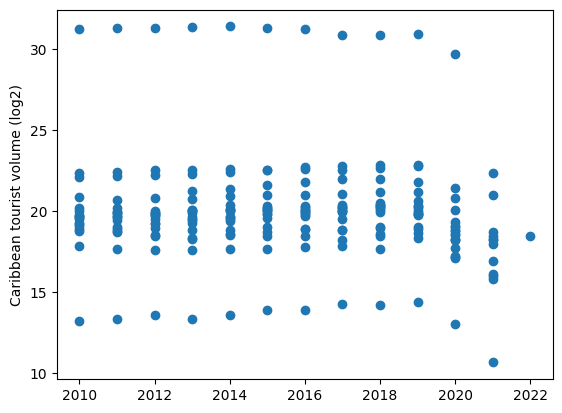

In [465]:
plt.scatter(x=df['yr'], y=np.log2(df['inbtou_volume']))
plt.ylabel("Caribbean tourist volume (log2)")
plt.show()

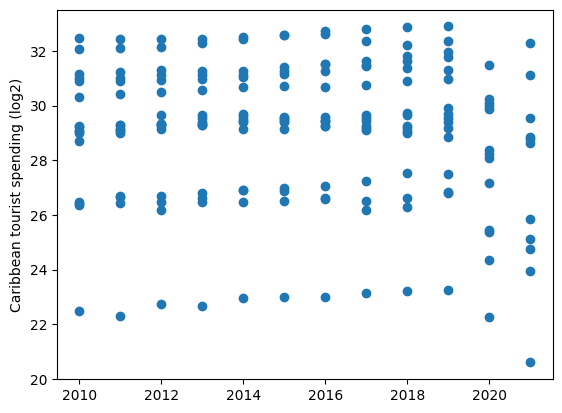

In [466]:
plt.scatter(x=df['yr'], y=np.log2(df['inbtou_spending']))
plt.ylabel("Caribbean tourist spending (log2)")
plt.show()